# Text Mining, Preprocessing, & Semantic Indexing

**About**

> Let's imagine you are a data-scientist for TEDx, and you want to understand more about the audience in one of the most popular videos "My philosophy for a happy life" -- on TEDx Talk Youtube channel.

**goal**

* Find the most relevant comments to the description.

*Below is an example of how quickly it is to scrape comments from any video without the youtube API.*

In [1]:
from david.utils import timeit
import david

from tedxtalks import sam_berns
sam_berns # dictionary with information about the video.

{'video_id': '36m1o-tM05g',
 'title': 'My philosophy for a happy life | Sam Berns | TEDxMidAtlantic',
 'author': 'Sam Berns',
 'views': 35940904,
 'likes': 623000,
 'dislikes': 12000,
 'comments': 42126,
 'about_video': 'Just before his passing on January 10, 2014, Sam Berns was a Junior at Foxboro High School in Foxboro, Massachusetts, where he achieved highest honors and was a percussion section leader in the high school marching band. He also achieved the rank of Eagle Scout in the Boy Scouts of America. Sam was diagnosed with Progeria, a rare, rapid aging disease, at the age of 2. He is featured in the Emmy award-winning documentary Life According to Sam, which premiered on HBO on October 21, 2013, 2 days before his 17th birthday.',
 'about_tedx': 'In the spirit of ideas worth spreading, TEDx is a program of local, self-organized events that bring people together to share a TED-like experience. At a TEDx event, TEDTalks video and live speakers combine to spark deep discussion and c

#### scraping comments

> With the `david.YTCommentsScraper.scrape_comments` Instance method you can scrape any amount of comments without API restrictions. To avoid re-downloading over 40K comments, I recommend saving and loading from a file with the `david.File.write_jsonl` and `david.File.read_jsonl` instance methods.

* This also works if you are working with small comment counts:

```python
...
scraping_task = david.YTCommentsScraper().scrape_comments(sam_berns["video_id"])
 # pass the generator to the Pipeline with the list function to initialize the scrapper.
pipe_tedx = david.Pipeline(list(scraping_task))
```

In [2]:
# construct a File object (returns a generator).
file = david.File(path="tedx-data")
# construct a YTCommentScraper object.
scraper = david.YTCommentScraper()

In [ ]:
# scraper (returns a generator).
scraping_task = scraper.scrape_comments(sam_berns["video_id"])

@timeit
def scraper_task():
    file.write_jsonl(scraping_task, "comments.jsonl", text_only=False)
# it took ~29.59 minutes to scrape 42,126 thousand comments ( no API fees 🤗 ).
scraper_task()

#### saving, loading and filtering data

> Since its a large dataset we can also split the samples by replies or no-replies.

In [3]:
comments = list(file.read_jsonl("tedx-data/comments.jsonl"))

# filter comments with replies only and save them to a jsonl file.
file.write_jsonl(filter(lambda k: len(k["cid"]) > 26, comments),
                 "comments_with_replies.jsonl", text_only=False)

# filter comments without replies and save them to a jsonl file.
file.write_jsonl(filter(lambda k: len(k["cid"]) == 26, comments),
                 "comments_without_replies.jsonl", text_only=False)

#### creating a pipeline

> `david.Pipeline` class has all the necessary methods for working and preprocessing sequences, along with with all the pandas DataFrame functionality, for easy data exploration.

In [4]:
comments_without_replies = file.read_jsonl("tedx-data/comments_without_replies.jsonl")
pipe_tedx = david.Pipeline(comments_without_replies)

# drop any duplicates to avoid unnecessary computation.
pipe_tedx.drop_duplicates(subset=["text"], inplace=True)
pipe_tedx.get_sequence_metrics(sentiment=True, tags=True)
pipe_tedx["text"].head()

0                       Matko on wygląda jak ufoludek.
1                    he deserves living rather than me
2                      R.I.P I feel so bad for him!!😭😭
3    I am literally fed up with life but just rolli...
4                               Ale polskiego nie ma..
Name: text, dtype: object

#### metrics : sentiment analysis

> The `david.Pipeline.get_sequence_metrics` instance method extracts multiple sequence metrics, and here is an example of using the sentiment metrics obtained for all sequences in the dataset.

**about sentiment scores**

* negative vs positive scores : `(-1.0 => +1.0)`

* objective vs subjective scores : `(+0.0 => +1.0)`

**definitions**

* `subjective` : Refers to personal perspectives, feelings, or opinions entering the decision making process.

* `objective` : Refers to the elimination of subjective perspectives and a process that is purely based on hard facts.

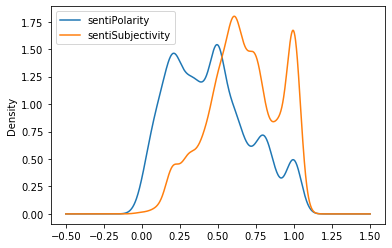

In [5]:
sentiment_columns = ["sentiPolarity", "sentiSubjectivity", "text"]
positive = pipe_tedx.loc[pipe_tedx["sentiPolarity"] > 0, sentiment_columns]
negative = pipe_tedx.loc[pipe_tedx["sentiPolarity"] < 0, sentiment_columns]
positive[sentiment_columns].plot.density()

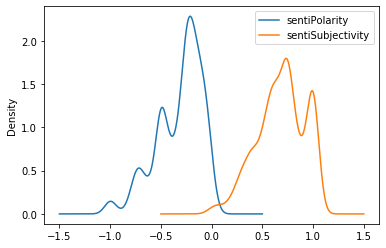

In [6]:
negative[sentiment_columns].plot.density()

> Let us take a closer look at the texts from the dataset to see how our the raw-form of the sequences look. We will then follow with preprocessing all the sequences and inspect for improvements.

In [7]:
david.top_trigrams(positive["text"], n=10)

[('rest in peace', 225),
 ('thank you for', 94),
 ('thank you sam', 78),
 ('god bless you', 49),
 ('in peace sam', 49),
 ('he is so', 45),
 ('this young man', 40),
 ('you so much', 38),
 ('change the world', 35),
 ('sam you are', 34)]

In [8]:
david.top_trigrams(negative["text"], n=10)

[('rest in peace', 30),
 ('disliked this video', 23),
 ('he looks like', 23),
 ('month after this', 18),
 ('people who disliked', 17),
 ('who disliked this', 15),
 ('that he died', 15),
 ('died month after', 15),
 ('like an alien', 15),
 ('he died month', 14)]

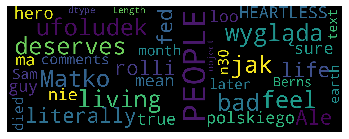

In [9]:
# a word cloud can, in a sense, give us a "summary" of all the tokens in the dataset.
david.build_wordcloud(pipe_tedx["text"], "pipe_tedx_raw.png")

#### preprocessing

> In the following steps, we will preprocess all our sequences without much effort as `david.Pipeline.clean_sequences` an instance method is aware of the social-media context and comes with all the necessary techniques to properly clean, normalize and reduce weight for all the sequences in the pipeline, all while keeping the meaning and intents of each comment.

* In the steps below we reduce size of the dataset : `9031 -> 8602 -> 6921 -> 5188`. Reducing noise for nlp models.

**optional**

* If you want to remove the top N most frequent words (for both: [ head + tail ]), I recommend using the `david.Pipeline.get_most_frequent_words` instance method. You can pass an empty set if you want to inspect the output, or you can pass your custom stop word list/set and include the top most frequent words. Below is an example:

```python
# to get only the most frequent words in your dataset:
frequent_words = set()
frequent_words = pipe_tedx.get_most_frequent_words(10, frequent_words)

# to extend an existing stop word set/list:
my_stop_words = ["a", "b", "c"]
my_stop_words = pipe_tedx.get_most_frequent_words(40, my_stop_words)
```

In [10]:
@timeit
def cleaning_task():
    pipe_tedx.clean_sequences(lemmatize=True, tags=True, wiggles=True)
cleaning_task() # it took about ~19 seconds to preprocess 8602 sequences.

( 'cleaning_task' ) took: 18943.80 ms


In [11]:
# depending on your preprocessing steps dropping
# empty and duplicates is recommended.
pipe_tedx.drop_duplicates(subset=["text"], inplace=True)
pipe_tedx.dropna(subset=["text"], inplace=True)

# re-calculate the string metric since the shape of the sequences
# changed after cleaning (we'll use the values for slicing)
pipe_tedx.string_metric()
pipe_tedx.stringLength.describe()

count    6921.000000
mean       41.200838
std        52.287205
min         0.000000
25%        15.000000
50%        27.000000
75%        48.000000
max      1229.000000
Name: stringLength, dtype: float64

In [12]:
# with the slice_shape method we select all where the string length is > 15
pipe_tedx_clean = pipe_tedx.slice_shape(min_val=15)
pipe_tedx_clean.stringLength.describe() # we now have no empty strings!

count    5188.000000
mean       51.596184
std        56.670095
min        16.000000
25%        24.000000
50%        35.000000
75%        58.000000
max      1229.000000
Name: stringLength, dtype: float64

> Inspecting the sequences after preprocessing

In [13]:
pos_clean = pipe_tedx_clean.loc[
    pipe_tedx_clean["sentiPolarity"] > 0, sentiment_columns
]
neg_clean = pipe_tedx_clean.loc[
    pipe_tedx_clean["sentiPolarity"] < 0, sentiment_columns
]
# our trigrams for positivity are more readable!
david.top_trigrams(pos_clean["text"], 10)

[('rest peace sam', 45),
 ('17 year old', 24),
 ('soul rest peace', 15),
 ('god bless sam', 15),
 ('sam rest peace', 13),
 ('live happy life', 12),
 ('philosophy happy life', 10),
 ('god bless soul', 10),
 ('people dislike video', 9),
 ('brave young man', 9)]

In [14]:
# We have improved our sequences. These
# improvements help NLP models like LDA or Word2Vec.
david.top_trigrams(neg_clean["text"], 10)

[('people dislike video', 17),
 ('look like alien', 13),
 ('die month speech', 10),
 ('rest peace sam', 9),
 ('alien area 51', 6),
 ('waste energy feel', 5),
 ('energy feel bad', 5),
 ('die month later', 4),
 ('area 51 alien', 4),
 ('sad pass away', 4)]

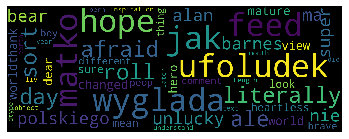

In [15]:
stopwords = pipe_tedx_clean.get_most_frequent_words(top_num=10)
david.build_wordcloud(pipe_tedx_clean["text"],
                      "pipe_tedx_clean.png", 
                      stop_words=stopwords)

### pipeline summary

> Lets now preprocess the comments with replies with the same steps we used above:

In [16]:
@timeit
def pipeline(
    fn: str,
    min_val=15,
    sentiment=True,
    lemmatize=True,
    tags=True,
    wiggles=True,
):
    """ My Ted-Talks text preprocessing pipeline. """
    file = david.File().read_jsonl(fn)
    pipe = david.Pipeline(file)
    pipe.drop_duplicates(subset=["text"], inplace=True)
    pipe.get_sequence_metrics(sentiment=sentiment, tags=tags)
    pipe.clean_sequences(lemmatize=lemmatize, tags=tags, wiggles=wiggles)
    pipe.drop_duplicates(subset=["text"], inplace=True)
    pipe.dropna(subset=["text"], inplace=True)
    pipe.string_metric()
    return pipe.slice_shape(min_val=min_val)

# it took ~69 seconds to preprocess 16K comments
tedx_pipe2 = pipeline("tedx-data/comments_with_replies.jsonl")

( 'pipeline' ) took: 69583.89 ms


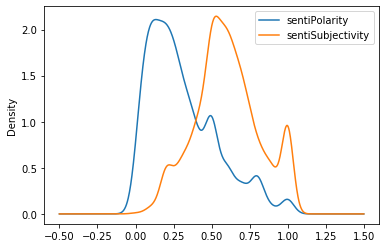

In [17]:
sentiment_columns = ["sentiPolarity", "sentiSubjectivity", "text"]
pos_2 = tedx_pipe2.loc[tedx_pipe2["sentiPolarity"] > 0, sentiment_columns]
neg_2 = tedx_pipe2.loc[tedx_pipe2["sentiPolarity"] < 0, sentiment_columns]
pos_2[sentiment_columns].plot.density()

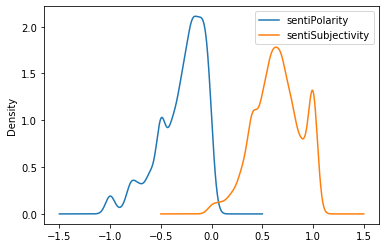

In [18]:
neg_2[sentiment_columns].plot.density()

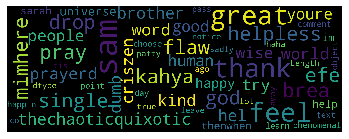

In [19]:
david.build_wordcloud(tedx_pipe2["text"], "tedx_conversations.png")

### NLP models ( gensim )

> Computing the TF-IDF (inverse document frequency). The rate is calculated based on statistics gathered from the whole corpus based on the portion of documents in which the word has occurred.

**arguements**

`update_every` : 0 => batch learning or 1 => online learning.

In [20]:
doc = pipe_tedx_clean["text"].tolist()

# lets train the model on 70 topics with batch learning.
lda_model, corpus, id2word = david.GensimLdaModel(doc, num_topics=70, update_every=0)
lda_model.print_topics()

12/06/2019 19:00:00 - INFO - gensim.models.phrases -   collecting all words and their counts
12/06/2019 19:00:00 - INFO - gensim.models.phrases -   PROGRESS: at sentence #0, processed 0 words and 0 word types
12/06/2019 19:00:01 - INFO - gensim.models.phrases -   collected 817 word types from a corpus of 267681 words (unigram + bigrams) and 5188 sentences
12/06/2019 19:00:01 - INFO - gensim.models.phrases -   using 817 counts as vocab in Phrases<0 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
12/06/2019 19:00:01 - INFO - gensim.models.phrases -   collecting all words and their counts
12/06/2019 19:00:01 - INFO - gensim.models.phrases -   PROGRESS: at sentence #0, processed 0 words and 0 word types
12/06/2019 19:00:01 - INFO - gensim.models.phrases -   collected 817 word types from a corpus of 267681 words (unigram + bigrams) and 5188 sentences
12/06/2019 19:00:01 - INFO - gensim.models.phrases -   using 817 counts as vocab in Phrases<0 vocab, min_count=5, threshold=100, m

12/06/2019 19:00:20 - INFO - gensim.models.ldamodel -   PROGRESS: pass 3, at document #1000/5188
12/06/2019 19:00:20 - INFO - gensim.models.ldamodel -   PROGRESS: pass 3, at document #2000/5188
12/06/2019 19:00:21 - INFO - gensim.models.ldamodel -   PROGRESS: pass 3, at document #3000/5188
12/06/2019 19:00:21 - INFO - gensim.models.ldamodel -   PROGRESS: pass 3, at document #4000/5188
12/06/2019 19:00:21 - INFO - gensim.models.ldamodel -   PROGRESS: pass 3, at document #5000/5188
12/06/2019 19:00:21 - INFO - gensim.models.ldamodel -   -9.436 per-word bound, 692.7 perplexity estimate based on a held-out corpus of 188 documents with 1162 words
12/06/2019 19:00:21 - INFO - gensim.models.ldamodel -   PROGRESS: pass 3, at document #5188/5188
12/06/2019 19:00:22 - INFO - gensim.models.ldamodel -   topic #22 (0.014): 0.029*"peace" + 0.028*"rest" + 0.025*"man" + 0.025*"people" + 0.024*"life" + 0.017*"probably" + 0.017*"brilliant" + 0.015*"message" + 0.015*"young" + 0.013*"fantastic"
12/06/2019

12/06/2019 19:00:27 - INFO - gensim.models.ldamodel -   PROGRESS: pass 7, at document #3000/5188
12/06/2019 19:00:27 - INFO - gensim.models.ldamodel -   PROGRESS: pass 7, at document #4000/5188
12/06/2019 19:00:28 - INFO - gensim.models.ldamodel -   PROGRESS: pass 7, at document #5000/5188
12/06/2019 19:00:28 - INFO - gensim.models.ldamodel -   -9.300 per-word bound, 630.4 perplexity estimate based on a held-out corpus of 188 documents with 1162 words
12/06/2019 19:00:28 - INFO - gensim.models.ldamodel -   PROGRESS: pass 7, at document #5188/5188
12/06/2019 19:00:28 - INFO - gensim.models.ldamodel -   topic #26 (0.014): 0.135*"beautiful" + 0.132*"soul" + 0.037*"pure" + 0.035*"share" + 0.026*"heart" + 0.021*"think" + 0.019*"thank" + 0.019*"great" + 0.018*"life" + 0.018*"people"
12/06/2019 19:00:28 - INFO - gensim.models.ldamodel -   topic #65 (0.014): 0.109*"big" + 0.035*"child" + 0.024*"video" + 0.021*"bear" + 0.018*"small" + 0.017*"brain" + 0.014*"life" + 0.013*"head" + 0.012*"ashamed

12/06/2019 19:00:31 - INFO - gensim.models.ldamodel -   topic #38 (0.014): 0.137*"alien" + 0.093*"believe" + 0.044*"look" + 0.030*"motivation" + 0.021*"small" + 0.021*"happy" + 0.019*"life" + 0.015*"people" + 0.014*"possible" + 0.013*"be"
12/06/2019 19:00:31 - INFO - gensim.models.ldamodel -   topic #2 (0.014): 0.062*"play" + 0.036*"mind" + 0.035*"hear" + 0.030*"great" + 0.030*"rip" + 0.028*"courage" + 0.022*"ago" + 0.021*"be" + 0.021*"thank" + 0.020*"glad"
12/06/2019 19:00:31 - INFO - gensim.models.ldamodel -   topic #35 (0.014): 0.056*"precious" + 0.039*"courageous" + 0.027*"human" + 0.026*"individual" + 0.025*"power" + 0.024*"race" + 0.024*"live" + 0.019*"great" + 0.018*"sharing" + 0.018*"content"
12/06/2019 19:00:31 - INFO - gensim.models.ldamodel -   topic #64 (0.014): 0.032*"look" + 0.025*"life" + 0.020*"people" + 0.018*"feel" + 0.018*"true" + 0.016*"sorry" + 0.016*"dream" + 0.012*"know" + 0.012*"come" + 0.010*"think"
12/06/2019 19:00:31 - INFO - gensim.models.ldamodel -   topic 

[(67,
  '0.039*"thank" + 0.027*"live" + 0.024*"life" + 0.021*"good" + 0.019*"happy" + 0.015*"long" + 0.015*"light" + 0.014*"health" + 0.014*"find" + 0.014*"thing"'),
 (39,
  '0.029*"future" + 0.025*"life" + 0.024*"good" + 0.022*"forget" + 0.016*"use" + 0.015*"explain" + 0.015*"amazing" + 0.013*"food" + 0.013*"ok" + 0.012*"people"'),
 (31,
  '0.063*"wish" + 0.041*"huge" + 0.033*"life" + 0.030*"good" + 0.028*"lose" + 0.027*"people" + 0.025*"inspire" + 0.024*"hat" + 0.019*"bring" + 0.017*"happy"'),
 (44,
  '0.031*"actually" + 0.028*"normal" + 0.028*"life" + 0.020*"people" + 0.020*"lesson" + 0.017*"love" + 0.015*"reason" + 0.013*"be" + 0.013*"learn" + 0.013*"recommendation"'),
 (7,
  '0.073*"family" + 0.065*"dear" + 0.042*"thank" + 0.017*"love" + 0.016*"face" + 0.014*"bless" + 0.013*"compare" + 0.013*"people" + 0.013*"state" + 0.012*"feel"'),
 (1,
  '0.115*"true" + 0.053*"wrong" + 0.045*"dream" + 0.044*"people" + 0.041*"dead" + 0.026*"wtf" + 0.025*"look" + 0.025*"mean" + 0.023*"life" + 0.0

In [21]:
import pyLDAvis
import pyLDAvis.gensim
# create a visual representation of the topic models for inspection:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
pyLDAvis.save_html(vis, 'tedx_talks_sam_berns.html')

12/06/2019 19:00:32 - INFO - numexpr.utils -   NumExpr defaulting to 8 threads.
/home/ego/anaconda3/envs/david/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### semantic indexing with gensim

> Finding the similarity between a video description and a set of document sequences (comments):

**summary of LSI** [wikipedia](https://en.wikipedia.org/wiki/Latent_semantic_analysis#Latent_semantic_indexing)

> LSI automatically adapts to new and changing terminology, and has been shown to be very tolerant of noise . This is especially important for applications using text derived from Optical Character Recognition and speech-to-text conversion. LSI is also used to perform automated document categorization. Because it uses a strictly mathematical approach, LSI is inherently independent of language. This enables LSI to elicit the semantic content of information written in any language without requiring the use of auxiliary structures, such as dictionaries and thesauri.

In [23]:
def lantent_sematic_indexing(documents, sims, threshold=0.80):
    """ Similarity interface for semantic indexing. Cosine measure returns
    similarities in the range <-1, 1> (the greater, the more similar).
    """
    similar_docs = list()
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    for _, (doc_id, sim_score) in enumerate(sims):
        if sim_score > threshold:
            similar_docs.append([(doc_id, sim_score), documents[doc_id]])
    return similar_docs

In [24]:
from collections import Counter
from david import preprocess_sequence
import gensim

about_video = preprocess_sequence(sam_berns["about_video"], lemmatize=True, tokenize=True)
VIDEO_DESCR, _ = zip(*Counter(about_video).most_common())

# contruct a LsiModel object
lsi = gensim.models.LsiModel(corpus, id2word=id2word, num_topics=70)
vec_bow = id2word.doc2bow(VIDEO_DESCR) # convert the video descriptions to LSI space.
vec_lsi = lsi[vec_bow]

# now transform the corpus to LSI space.
index = gensim.similarities.MatrixSimilarity(lsi[corpus])
index.save("/tmp/tedxtalk.index") # save the model.
index = gensim.similarities.MatrixSimilarity.load("/tmp/tedxtalk.index") # load the model.
sims = index[vec_lsi]
print(list(enumerate(sims))[:10])

12/06/2019 19:03:21 - INFO - gensim.models.lsimodel -   using serial LSI version on this node
12/06/2019 19:03:21 - INFO - gensim.models.lsimodel -   updating model with new documents
12/06/2019 19:03:21 - INFO - gensim.models.lsimodel -   preparing a new chunk of documents
12/06/2019 19:03:21 - INFO - gensim.models.lsimodel -   using 100 extra samples and 2 power iterations
12/06/2019 19:03:21 - INFO - gensim.models.lsimodel -   1st phase: constructing (3588, 170) action matrix
12/06/2019 19:03:21 - INFO - gensim.models.lsimodel -   orthonormalizing (3588, 170) action matrix
12/06/2019 19:03:22 - INFO - gensim.models.lsimodel -   2nd phase: running dense svd on (170, 5188) matrix
12/06/2019 19:03:22 - INFO - gensim.models.lsimodel -   computing the final decomposition
12/06/2019 19:03:22 - INFO - gensim.models.lsimodel -   keeping 70 factors (discarding 24.592% of energy spectrum)
12/06/2019 19:03:22 - INFO - gensim.models.lsimodel -   processed documents up to #5188
12/06/2019 19:03:

[(0, 0.059385445), (1, 0.5651262), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.046220206), (6, 0.03373549), (7, 0.027354177), (8, 0.026030155), (9, 0.03675599)]


In [25]:
# do the comments match the video description?
" ".join(VIDEO_DESCR)

'sam high foxboro school achieve scout age 2 passing january 10 2014 bern junior massachusetts honor percussion section leader march band rank eagle boy america diagnose progeria rare rapid disease featured emmy awardwining documentary life accord premier hbo october 21 2013 day 17th birthday'

> Obtain the most "semantically" similar comments to the description of the video

In [66]:
similar_matches = lantent_sematic_indexing(doc, sims, threshold=0.50)
similar_matches[:20] # top 20 matches @ threshold > 0.50 from 5188 samples.

[[(1288, 0.79954195),
  'god promise restoration include raise graf restore life bring health ness'],
 [(832, 0.7797595), 'damn realize life'],
 [(4333, 0.7558033),
  'like real life version film jack star boy robin williams'],
 [(3702, 0.753907), 'instead complain life thankful'],
 [(1254, 0.75357246), 'million bum wasting away life perfectly healthy'],
 [(683, 0.7476773), 'right complain life'],
 [(4298, 0.747625), 'awesome kid life ambition'],
 [(2334, 0.74430954), 'fought life squashed cell effort theyl grow ok'],
 [(3596, 0.7434384),
  'l stop complain life easily meeting difficulty problem forget yr sam bern thank q'],
 [(4914, 0.74324405), 'omg guy troll pl second life o'],
 [(2204, 0.74289954), 'confident worry desease life'],
 [(733, 0.7423527), 'life perspective sure'],
 [(4285, 0.7407938), 'understand life alot'],
 [(2908, 0.7397683), 'rip sam wish life advice'],
 [(810, 0.73915696), 'man paradise mind et teacher life'],
 [(4043, 0.73615205),
  'trophy snowflake star footbal

In [68]:
similar_indexes, similar_comments = zip(*similar_matches)
print("*", david.top_unigrams(similar_comments), end="\n\n")
print("*", david.top_bigrams(similar_comments), end="\n\n")
print("*", david.top_trigrams(similar_comments))

* [('life', 212), ('sam', 29), ('happy', 26), ('live', 23), ('hope', 18)]

* [('happy life', 15), ('live life', 8), ('complain life', 6), ('rip sam', 6), ('life god', 6)]

* [('life god bless', 3), ('like real life', 2), ('stop complain life', 2), ('hope life god', 2), ('rest peace sam', 2)]


#### summary

> From the results, we can see that we can apply $LSI$ as a useful solution to conceptual matching problems. $LSI$, along with $LDA$, can be used when dealing with capturing essential relationship/taxonomic information dynamically on topics *(clusters)* from `unstructured text` -> youtube comments, or other social-media content.

* TODO: continue exploring this technique ( `comments == description` ) further with youtube comments on different categories.

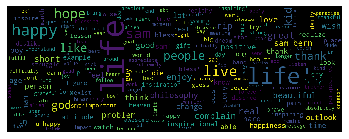

In [69]:
david.build_wordcloud(similar_comments, "semantically_similar_comments.png")